# Krafthack 2022 Additive neural newtork model

In [90]:
import pandas as pd
import plotly.express as px
import numpy as np
from matplotlib import pyplot as plt
import os
import pickle

In [92]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import utils

# Set random seed for reproducability
tensorflow.random.set_seed(0)

print("Libraries imported.")
print('Keras version:',keras.__version__)
print('TensorFlow version:',tensorflow.__version__)

Libraries imported.
Keras version: 2.8.0
TensorFlow version: 2.8.0


In [93]:
from data_helpers import get_operating_signal_names, get_tensile_sensor_names
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [94]:
data = pd.read_parquet('../data/detrended_steady_data.parquet')
data = data.dropna()
data = data.drop_duplicates()
data.head()

,Unit_4_Power,Unit_4_Reactive Power,Turbine_Guide Vane Opening,Turbine_Pressure Drafttube,Turbine_Pressure Spiral Casing,Turbine_Rotational Speed,Bolt_1_Tensile,Bolt_2_Tensile,Bolt_3_Tensile,Bolt_4_Tensile,Bolt_5_Tensile,Bolt_6_Tensile
timepoints,,,,,,,,,,,,
1970-09-11 00:00:00,216.010229,2.213785,72.927260,152.625396,5204.692439,107.993752,4.962772,-7.615786,-2.839481,-0.922153,-5.521569,-3.766545
1970-09-11 00:00:01,215.986387,2.430907,72.857113,152.426614,5204.907020,107.993752,5.031327,-7.592030,-2.878009,-0.940889,-5.516459,-3.691460
1970-09-11 00:00:02,215.962544,2.648030,72.786965,152.221141,5205.337213,107.993752,4.978194,-7.574893,-2.857521,-0.937066,-5.550948,-3.748036
1970-09-11 00:00:03,215.938701,2.865152,72.716817,152.015668,5205.767405,107.993752,4.894897,-7.659141,-2.939444,-0.951310,-5.510674,-3.769048
1970-09-11 00:00:04,215.914859,3.082275,72.646670,151.810195,5206.197597,107.993752,4.989375,-7.563591,-2.863004,-0.983190,-5.588106,-3.776209


In [95]:
input_scaler = StandardScaler().fit(data.loc[:,get_operating_signal_names()].values)

In [96]:
with open('steady_data_scaler.pkl','wb') as f:
    pickle.dump(input_scaler,f)

In [97]:
x_train, x_test, y_train, y_test = train_test_split(data.reindex(columns=get_operating_signal_names()).values,
                                                    data.reindex(columns=get_tensile_sensor_names()).values,
                                                    test_size=0.30,
                                                    random_state=0)

x_test = input_scaler.transform(x_test)
x_train = input_scaler.transform(x_train)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

y_test = y_test.astype('float32')
y_train = y_train.astype('float32')

In [117]:
model = keras.Sequential(
    [
        layers.Dense(36, activation="relu"),
        layers.Dropout(0.1),
        layers.Dense(36, activation="relu"),
        layers.Dropout(0.1),
        layers.Dense(len(get_tensile_sensor_names())),
    ]
)

callback_list = [keras.callbacks.EarlyStopping(monitor="val_mae", patience=3)]
model.compile(optimizer='rmsprop',loss='mse',metrics=['mae'])

In [118]:
num_epochs = 200
history = model.fit(x_train, y_train, epochs=num_epochs, batch_size=1024, validation_data=(x_test, y_test),callbacks=callback_list)
model.save('steady_additive_fitted_model')

Epoch 1/200
4344/4344 [==============================] - 10s 2ms/step - loss: 2.9824 - mae: 1.1980 - val_loss: 2.1955 - val_mae: 1.0025
Epoch 2/200
4344/4344 [==============================] - 8s 2ms/step - loss: 2.4227 - mae: 1.0644 - val_loss: 1.9903 - val_mae: 0.9453
Epoch 3/200
4344/4344 [==============================] - 8s 2ms/step - loss: 2.3185 - mae: 1.0386 - val_loss: 1.9055 - val_mae: 0.9287
Epoch 4/200
4344/4344 [==============================] - 7s 2ms/step - loss: 2.2649 - mae: 1.0256 - val_loss: 1.8617 - val_mae: 0.9139
Epoch 5/200
4344/4344 [==============================] - 7s 2ms/step - loss: 2.2399 - mae: 1.0182 - val_loss: 1.8416 - val_mae: 0.9106
Epoch 6/200
4344/4344 [==============================] - 8s 2ms/step - loss: 2.2264 - mae: 1.0135 - val_loss: 1.8253 - val_mae: 0.9064
Epoch 7/200
4344/4344 [==============================] - 9s 2ms/step - loss: 2.2142 - mae: 1.0099 - val_loss: 1.8200 - val_mae: 0.9029
Epoch 8/200
4344/4344 [==============================]

ValueError: x and y must have same first dimension, but have shapes (200,) and (16,)

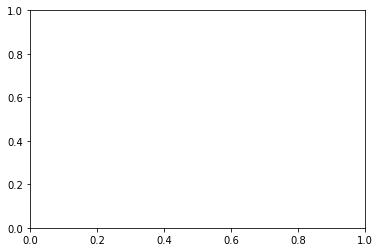

In [119]:
%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

INFO:tensorflow:Assets written to: steady_additive_model\assets
